In [1]:
import logging
import sys
import json
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import iperf_tools as ipt
import coordinator

In [2]:
# Define logging instance, attached to stdout
LOGGER = logging.getLogger()
LOGGER.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
LOGGER.addHandler(handler)

In [40]:
# Config for testing a single host
EXAMPLE_CONFIG_ONE_CLIENT = {
    "clients": [
        {
            "id": "1",
            "port": "5001",
            "interval": "0.5",
            "host": "192.168.1.129",
            "delay": "5",
            "tos": "0",
            "iperf_timeout": 30,
        },
    ]
}
# Config for two concurrent hosts
EXAMPLE_CONFIG_TWO_CLIENTS = {
    "clients": [
        {
            "id": "1",
            "port": "5001",
            "interval": "0.25",
            "host": "192.168.1.129",
            "duration": "30",
            "tos": "0x20",
            "delay": 0,
            "iperf_timeout": 180,
        },
        {
            "id": "2",
            "port": "5002",
            "interval": "0.25",
            "host": "192.168.1.129",
            "duration": "10",
            "tos": "0x00",
            "delay": 10,
            "iperf_timeout": 180,
        }
    ]
}

In [41]:
# Helpewr functions to access iperf tools and to create the coordinator object for a testrun
def start_client_tools(id, port, interval, host, delay, tos, iperf_timeout):
    results = [""]
    ipt.start_client(id, results, port, interval, host, delay, tos, iperf_timeout)
    return results[0]

def generate_single_client():
    co = coordinator.Coordinator(0, EXAMPLE_CONFIG_ONE_CLIENT)
    return co._generate_clients()


def start_two_clients():
    co = coordinator.Coordinator(0, EXAMPLE_CONFIG_TWO_CLIENTS)
    return co.run_experiment()

In [57]:
# Set experiment title and path for results
csv_tag = "del10_simply_triple_20v00_5"
folder = "wed/"
graph_folder = "del10_simply_triple_20v00/"

# Run experiment
sqm_results = start_two_clients()

Len results: 2
Client args for client 0: [0, [{'result': None, 'delay': 0}, {'result': None, 'delay': 0}], '5001', '0.25', '192.168.1.129', '30', '0x20', 0, 180]
Client args for client 1: [1, [{'result': None, 'delay': 0}, {'result': None, 'delay': 0}], '5002', '0.25', '192.168.1.129', '10', '0x00', 10, 180]
Thread at idx: 0 starting in 0 seconds.
Starting client at idx: 0
Shell statement: ['iperf3', '--port', '5001', '--format', 'k', '--interval', '0.25', '--json', '--client', '192.168.1.129', '--verbose', '--time', '30', '--reverse', '--tos', '0x20']
Thread at idx: 1 starting in 10 seconds.
Starting client at idx: 1
Shell statement: ['iperf3', '--port', '5002', '--format', 'k', '--interval', '0.25', '--json', '--client', '192.168.1.129', '--verbose', '--time', '10', '--reverse', '--tos', '0x00']


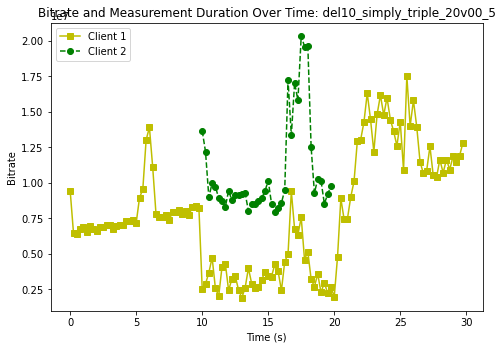

In [58]:
# Plot coordinator-side bps results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l1 = ax.plot(sqm_results[0]["start_time"],sqm_results[0]["bits_per_second"],'ys-') # solid line with yellow colour and square marker
l2 = ax.plot(sqm_results[1]["start_time"],sqm_results[1]["bits_per_second"],'go--') # dash line with green colour and circle marker
# ax.set_title(f"Bitrate and Measurement Duration Over Time: {csv_tag}")
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Bitrate')
plt.xlabel('Time (s)')
plt.ylabel('Bitrate')
plt.title(f"Bitrate and Measurement Duration Over Time: {csv_tag}")
ax.legend(labels = ('Client 1', 'Client 2'), loc = 'upper left')
# plt.show()

In [59]:
# Save coordinator side results to disk
sqm_results[0].to_csv(f"csvdump/{folder}coordinator_1_{csv_tag}.csv")
sqm_results[1].to_csv(f"csvdump/{folder}coordinator_2_{csv_tag}.csv")
fig.savefig(f"csvdump/{folder}graphs/coordinator/{graph_folder}coordinator_{csv_tag}.png", bbox_inches='tight', facecolor='white', transparent=False)
print("Written.")

Written.


To grab results from sensor:

`scp -r root@192.168.1.129:/home/pi/Documents/thesis-files/openwrt-packet-generator/csvdump/* sensor_csvdump`

In [60]:
# Helper function to translate a list of csvs to pandas DataFrames
def read_dfs(files, folders):
    dfs = []
    for idx, f in enumerate(files):
        dfs.append(pd.read_csv(f"{folders[idx]}/{files[idx]}.csv")) 
    return dfs

In [61]:
# Plot pairs of results for the given field,
# optionally save result to disk
def plot_files(files, dfs, field, show=False, save=False):
    line_types = ['ys--', 'go--', 'bd--']
    fig = plt.figure()
    ax = fig.add_axes([1,0,1,1])
    
    for idx, df in enumerate(dfs):
        ax.plot(df["start_time"], df[field], line_types[idx])
    ax.legend(labels = files, loc = 'upper left') # legend placed at lower right
    ax.set_title(f"{field} Over Time")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'{field}')
    if show:
        plt.show()
    if save:
        s = ""
        for f in files:
            s = s + f

        fig.savefig(f"csvdump/{folder}graphs/sensor/{graph_folder}sensor_{s}_{field}.png", bbox_inches='tight', facecolor='white', transparent=False)

In [62]:
# Average the bitrate and rtt of a result pair, compute the percentage difference
def compute_avg_bps(files, dfs):
    avg0 = dfs[0]["bits_per_second"].iloc[42:81].mean()
    avg1 = dfs[1]["bits_per_second"].mean()
    avg0_rtt = dfs[0]["rtt"].iloc[42:81].mean()
    avg1_rtt = dfs[1]["rtt"].mean()
    # pc_diff = abs(((avg0-avg1)/avg1) * 100)
    pc_diff_bps = (((avg0-avg1)/avg1) * 100)
    pc_diff_rtt = (((avg0_rtt-avg1_rtt)/avg1_rtt) * 100)
    return (pc_diff_bps, pc_diff_rtt)

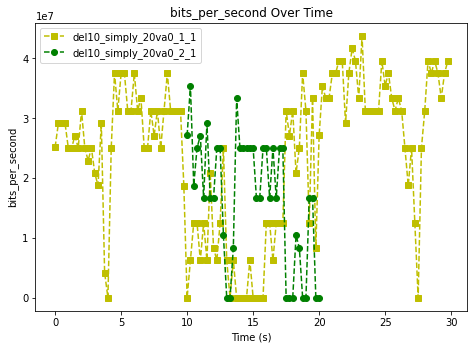

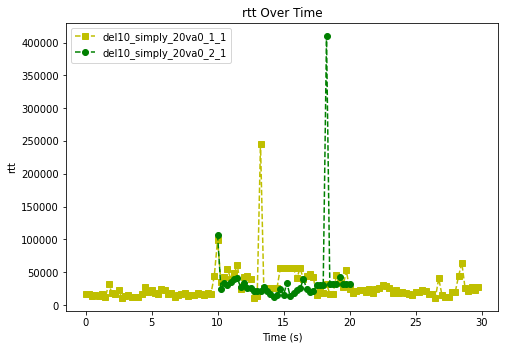

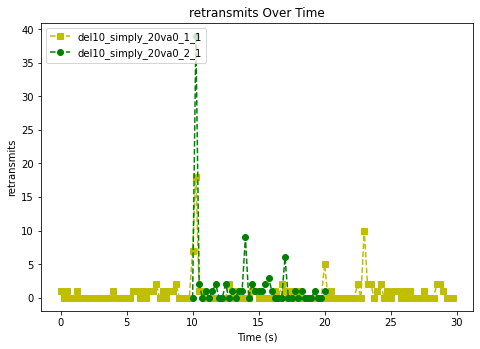

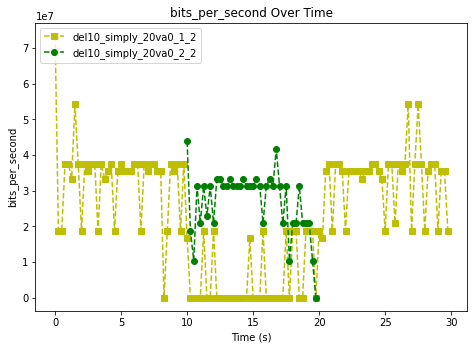

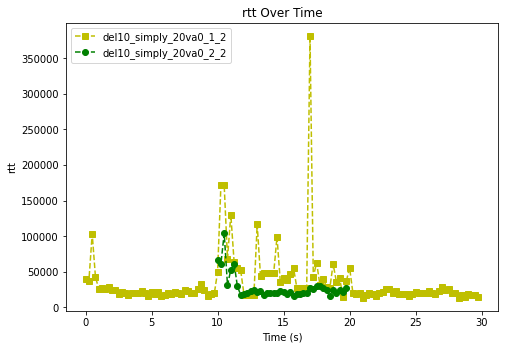

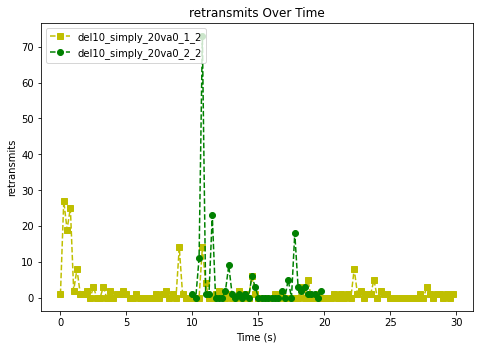

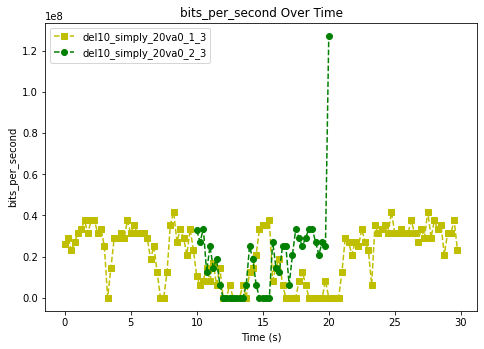

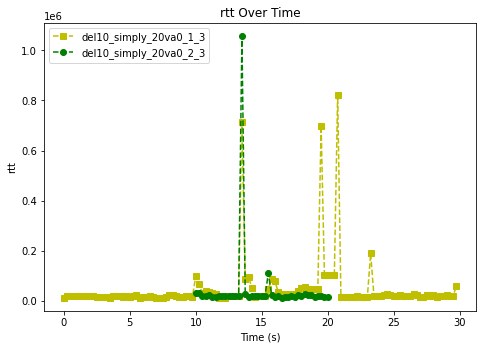

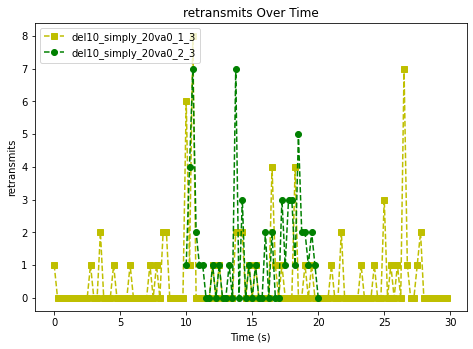

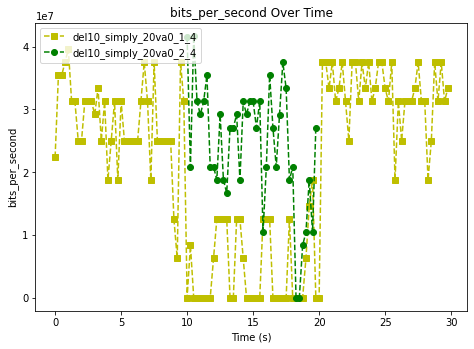

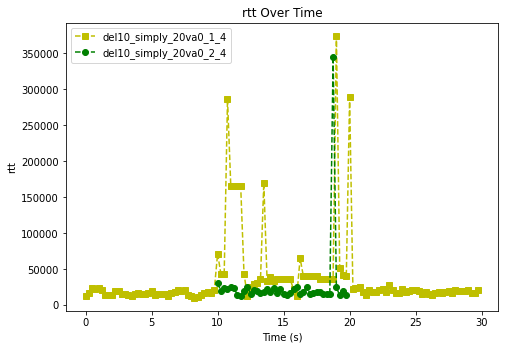

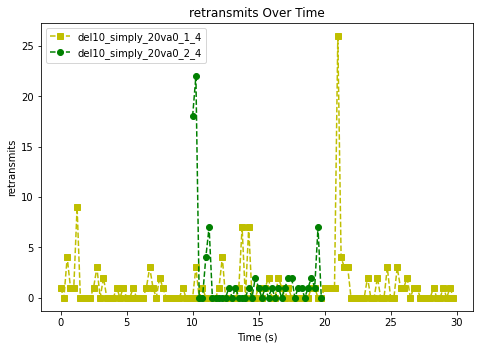

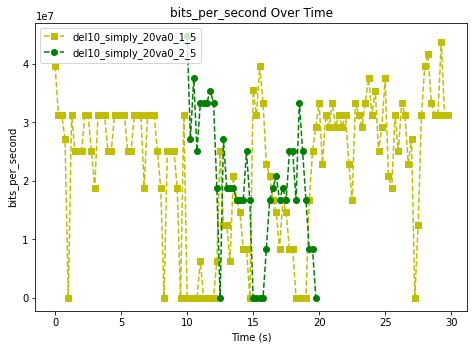

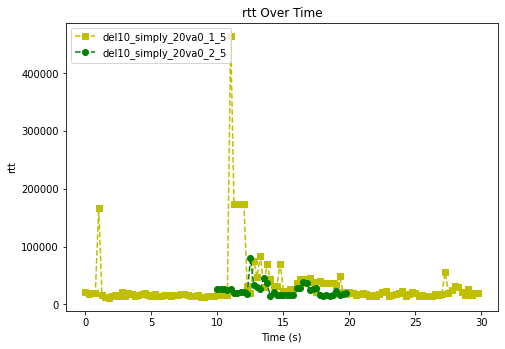

Average bps variation between clients: -53.78670182478263%
Average rtt variation between clients: 99.65532276396856%


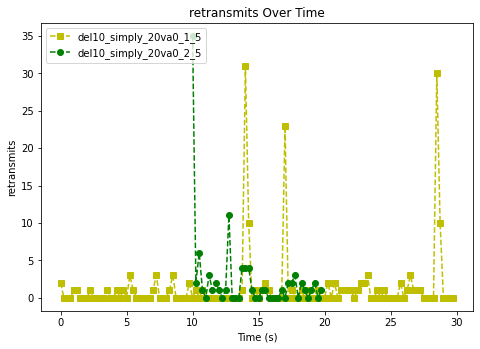

In [71]:
graph_folder = "del10_simply_20va0/"  # Folder to save result graph
filegroups = [
    ["del10_simply_20va0_1_1", "del10_simply_20va0_2_1"],
    ["del10_simply_20va0_1_2", "del10_simply_20va0_2_2"],
    ["del10_simply_20va0_1_3", "del10_simply_20va0_2_3"],
    ["del10_simply_20va0_1_4", "del10_simply_20va0_2_4"],
    ["del10_simply_20va0_1_5", "del10_simply_20va0_2_5"],
#     ["sensor_csvdump/del10_simple_triple_all_08v10_1_5.csv", "sensor_csvdump/del10_simple_triple_all_08v10_2_5.csv"],
]  # Define result pair file paths
folders = [
    ["sensor_csvdump/wed", "sensor_csvdump/wed"],
    ["sensor_csvdump/wed", "sensor_csvdump/wed"],
    ["sensor_csvdump/wed", "sensor_csvdump/wed"],
    ["sensor_csvdump/wed", "sensor_csvdump/wed"],
    ["sensor_csvdump/wed", "sensor_csvdump/wed"],
]  # Define result pair folder trees

bps = []
rtt = []
# Plot and optionally save all result pairs
for idx, g in enumerate(filegroups):
    dfs = read_dfs(filegroups[idx], folders[idx])
    plot_files(filegroups[idx], dfs, "bits_per_second", save=False, show=True)
    plot_files(filegroups[idx], dfs, "rtt", save=False, show=True)
    plot_files(filegroups[idx], dfs, "retransmits", save=False, show=False)
    bps.append(compute_avg_bps(filegroups[idx], dfs)[0])
    rtt.append(compute_avg_bps(filegroups[idx], dfs)[1])

print(f"Average bps variation between clients: {sum(bps)/len(bps)}%")
print(f"Average rtt variation between clients: {sum(rtt)/len(rtt)}%")